In [5]:
%matplotlib inline

In [6]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [11]:
# Set this to be the directory containing the data subdirectories
# (so xzIntensity and OMAG BScans are 2 levels down from this dir).
DATA_DIR = '/home/celine/projects/fydp/data'

In [13]:
# Decodes a grayscale PNG, returns a 2D tensor.
def load_image(file_name):
    image = tf.io.read_file(file_name)
    image = tf.image.decode_png(image)
    image = tf.squeeze(image)
    return image

In [14]:
# Returns a pair of tensors containing the given B-scan and its
# corresponding OMAG. |dir_path| should contain directories
# 'xzIntensity' and 'OMAG Bscans'. Scan files should be named
# <num>.png (no leading 0s), with a 4-to-1 ratio of B-scans to OMAGs.
# (OMAG Bscans/1.png corresponds to xzIntensity/{1,2,3,4}.png.)
def get_images(dir_path, bscan_num):
    bscan_img = load_image(
        os.path.join(dir_path, 'xzIntensity',
                     '{}.png'.format(bscan_num)))
    omag_num = (bscan_num // 4) + 1
    
    omag_img = load_image(
        os.path.join(dir_path, 'OMAG Bscans',
                     '{}.png'.format(omag_num)))
    
    return bscan_img, omag_img

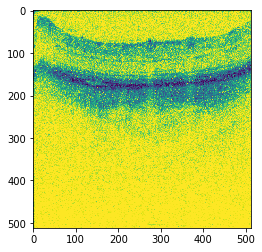

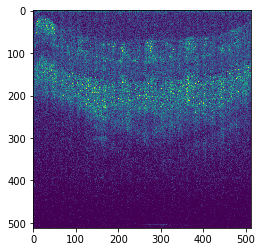

In [15]:
# Test dump input 100 from the '2015-08-11 Images50'
# dataset.
with tf.Session() as sess:
    input_img, output_img = get_images(
        os.path.join(DATA_DIR, '2015-08-11 Images50'), 100)
    plt.figure()
    plt.imshow(sess.run(input_img) / 255.0)
    plt.figure()
    plt.imshow(sess.run(output_img) / 255.0)